In [80]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from nltk.tokenize import RegexpTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from nltk import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import re
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import copy
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import numpy as np
from sklearn.cross_validation import train_test_split
import sys
from sklearn.grid_search import GridSearchCV
import time
from bigml.api import BigML
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
import preprocessing

In [2]:
df = pd.read_csv('data/churn.csv')

In [3]:
df.columns.tolist()

['State',
 'Account Length',
 'Area Code',
 'Phone',
 "Int'l Plan",
 'VMail Plan',
 'VMail Message',
 'Day Mins',
 'Day Calls',
 'Day Charge',
 'Eve Mins',
 'Eve Calls',
 'Eve Charge',
 'Night Mins',
 'Night Calls',
 'Night Charge',
 'Intl Mins',
 'Intl Calls',
 'Intl Charge',
 'CustServ Calls',
 'Churn?']

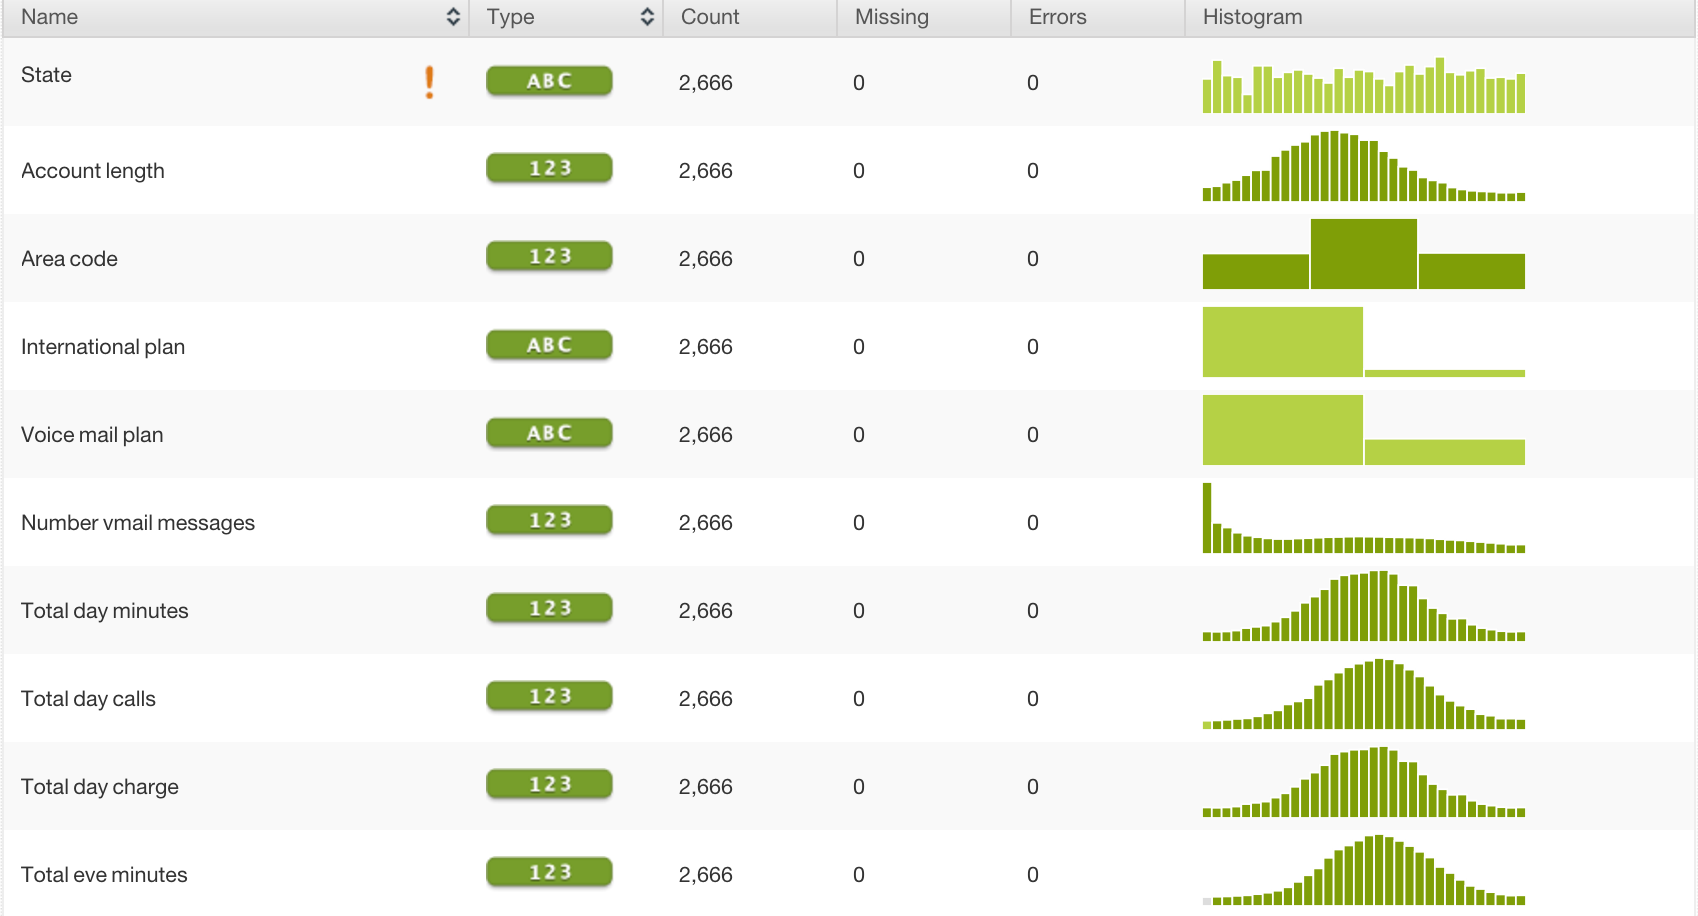

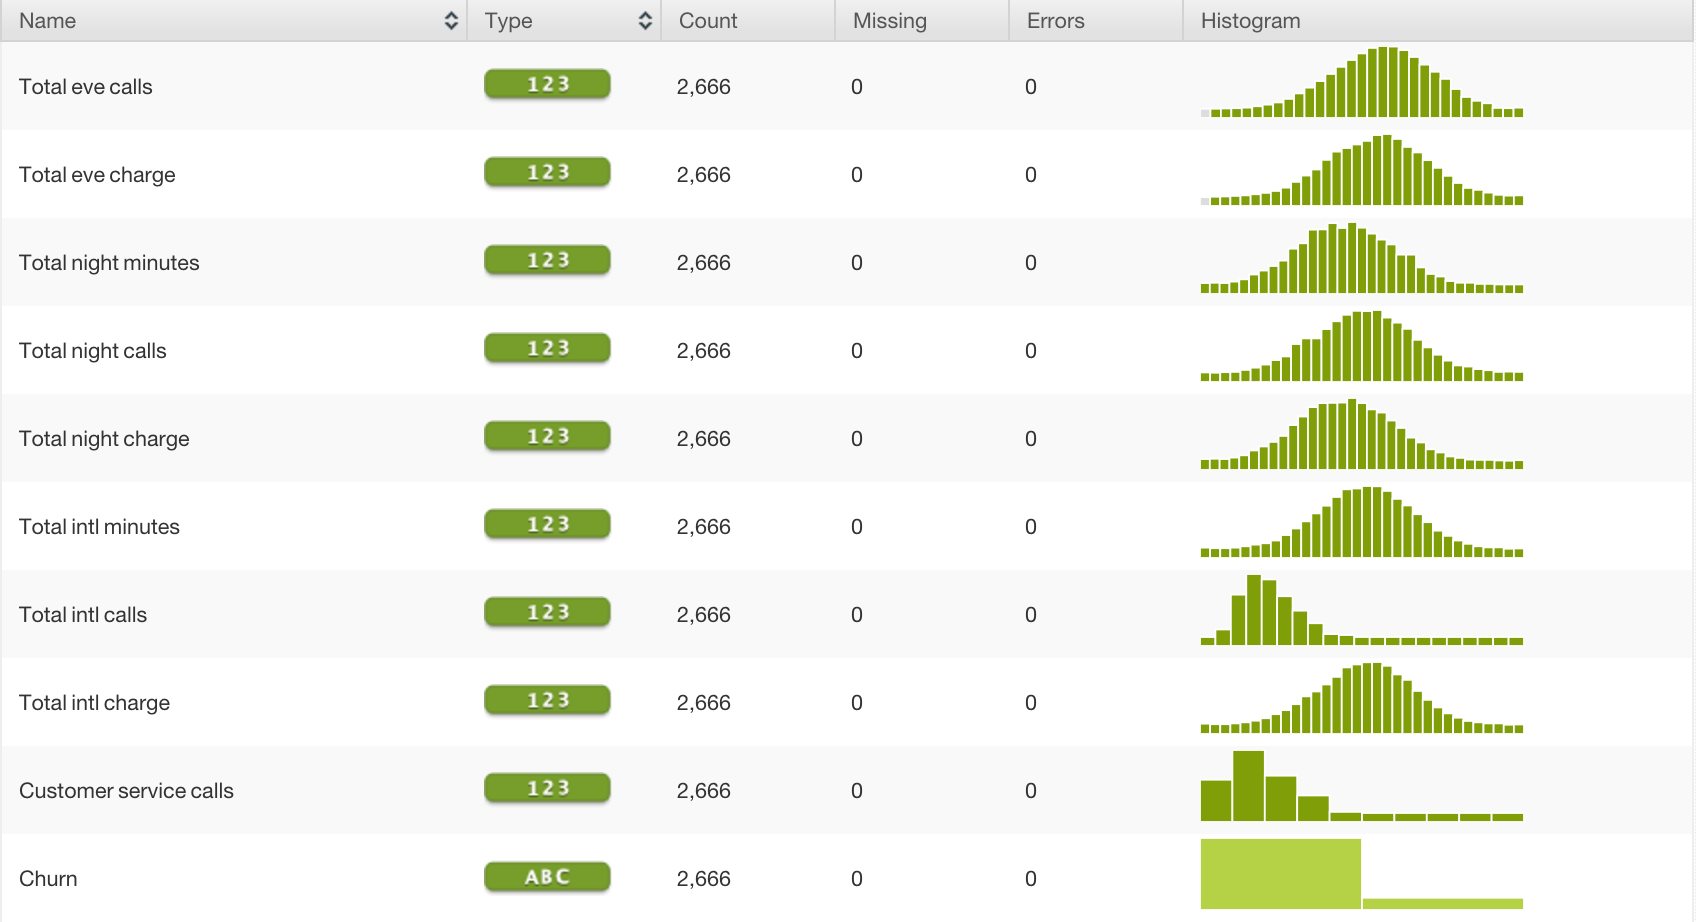

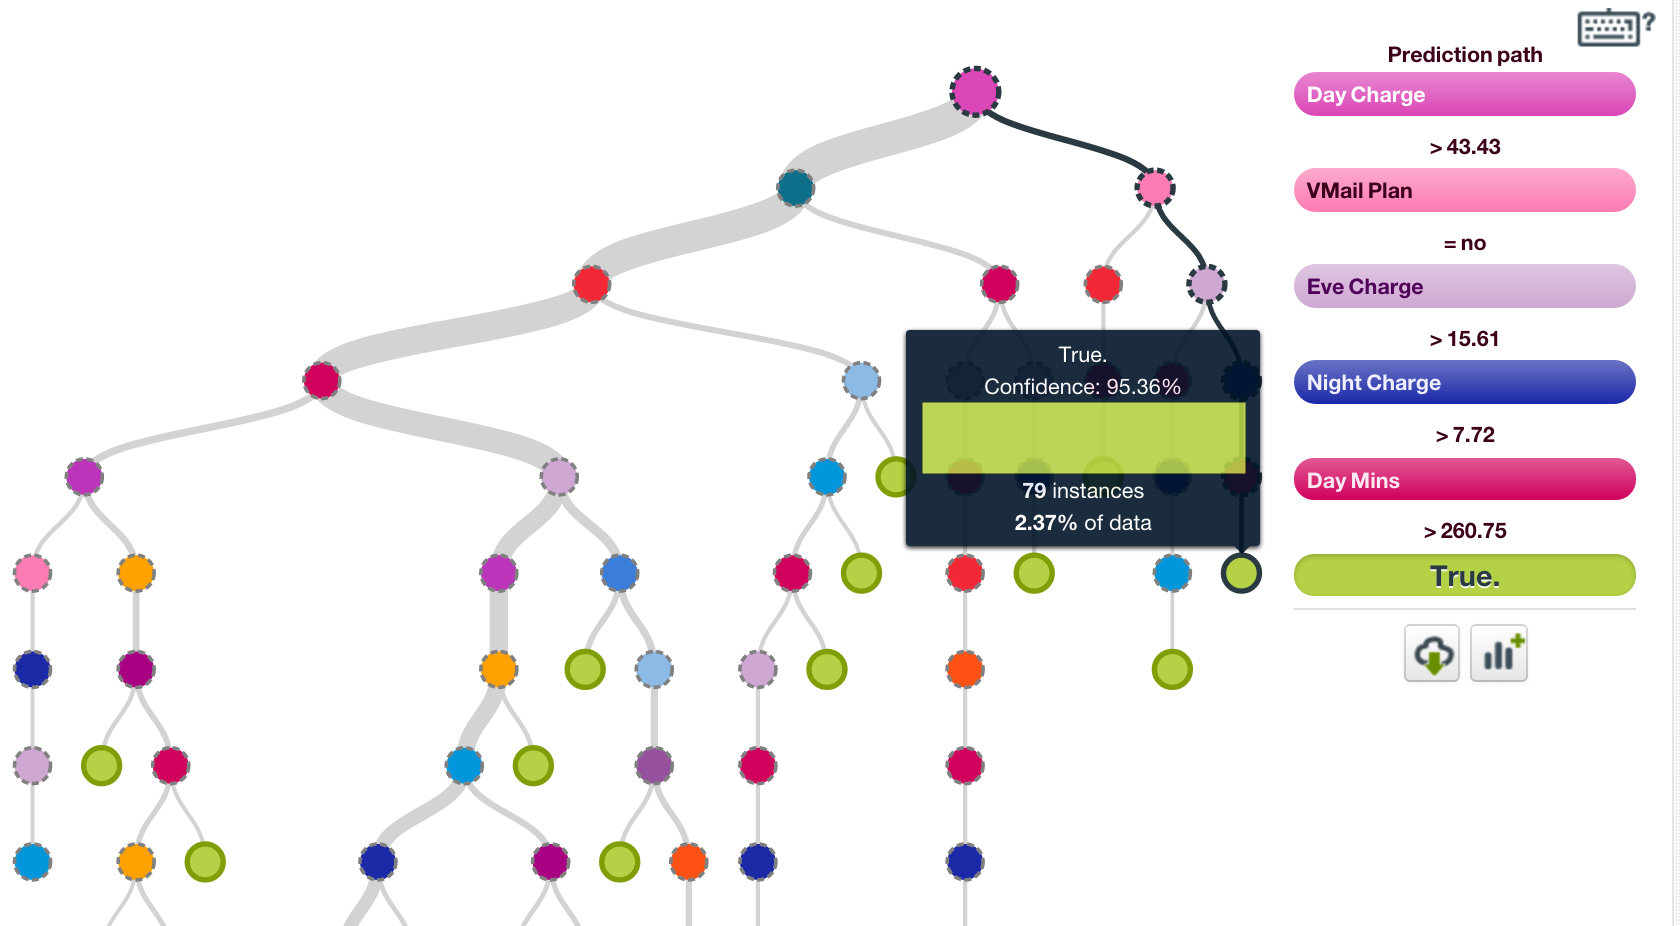

A decision tree represents a model where each node is associated with a question on a feature value, with a certain number of possible answers represented by branches, and where leaves are associated with output values. The first question is located at the root node. Choosing an answer takes you to a branch of the tree and to a next node. The process is repeated until a leaf is reached, where you get the associated output value as a prediction.

A sunburst chart or a multilevel pie chart, is used to visualize hierarchical data, depicted by concentric circles. The circle in the centre represents the root node, with the hierarchy moving outward from the center. A segment of the inner circle bears a hierarchical relationship to those segments of the outer circle which lie within the angular sweep of the parent segment. 

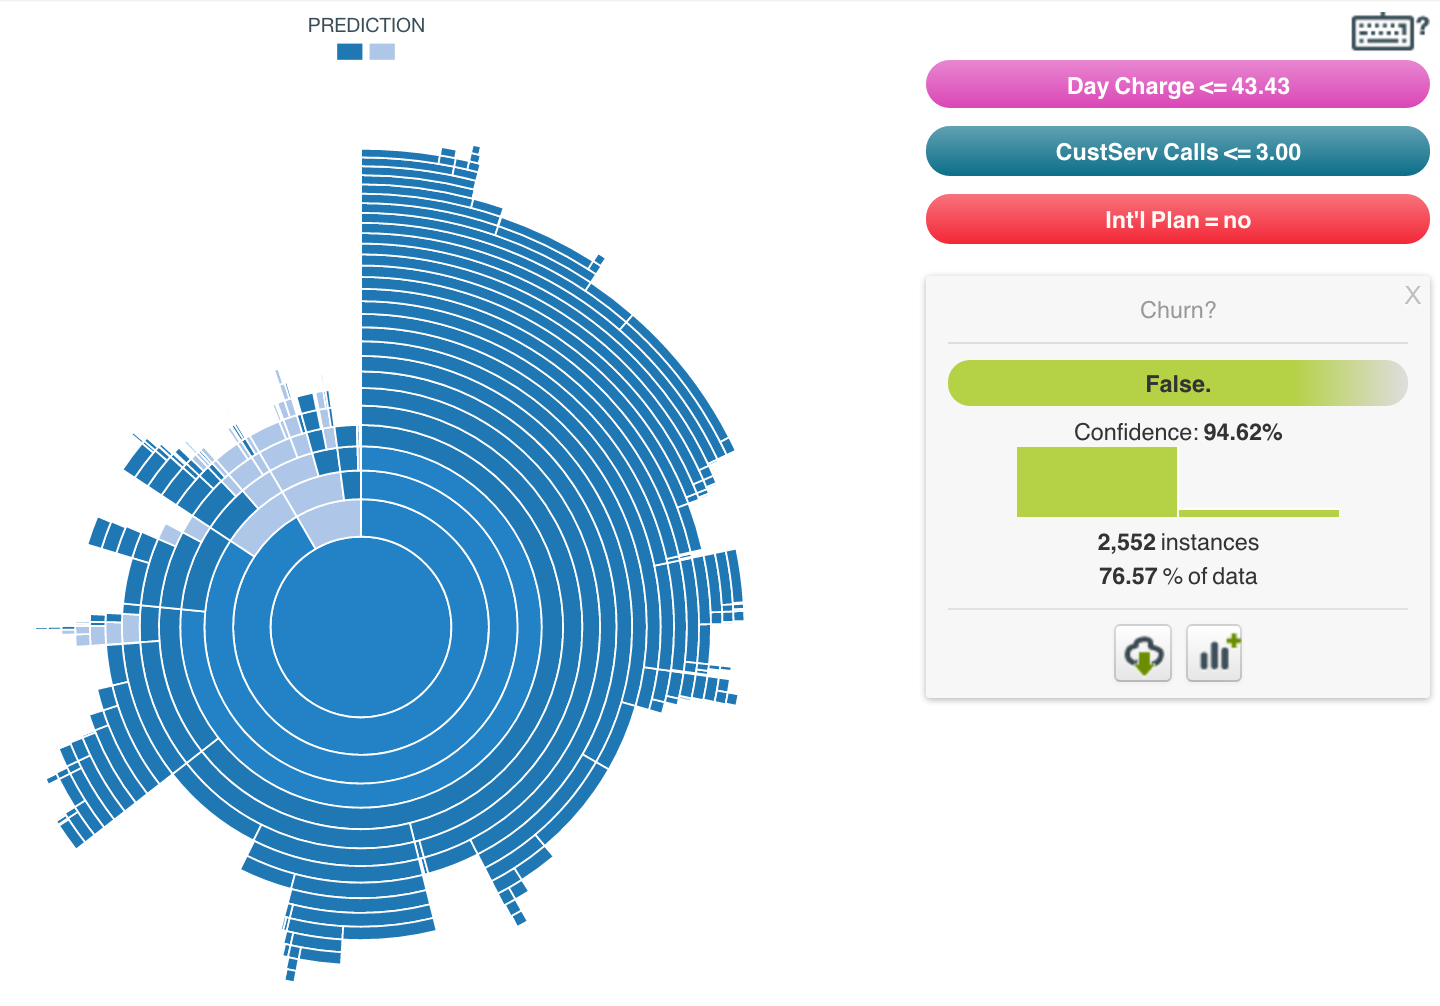

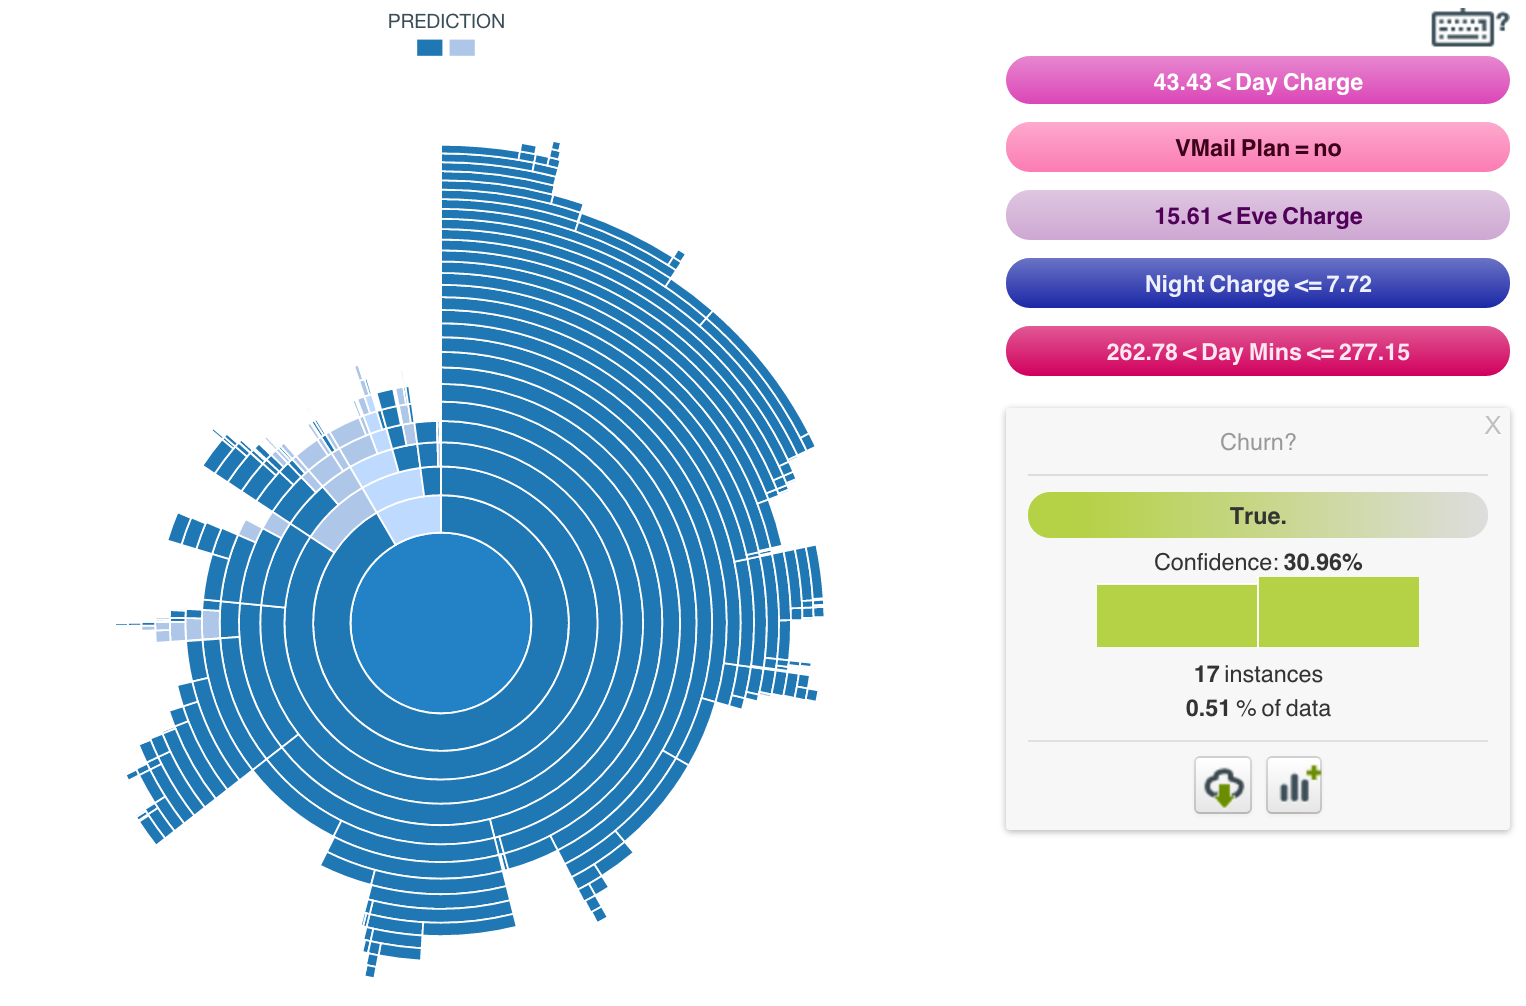

In [5]:
df['Churn?'] == "True."
labels = df["Churn?"]

In [6]:
features = df.drop(['State', 'Area Code', 'Phone', 'Churn?'], axis=1)

In [7]:
yes_no_cols = ["Int'l Plan", "VMail Plan"]
features[yes_no_cols] = (features[yes_no_cols] == 'yes')

In [25]:
features_names = features.columns

In [9]:
X = features.as_matrix().astype(np.float)

In [10]:
y = np.where(labels == 'True.',1,0)

In [11]:
#Scaling features
scaler = StandardScaler()

In [12]:
BINARY_FEATURES_NAME = ["Int'l Plan", "VMail Plan"]
FEATURES_NAME = features.columns
continuous_feats = features.drop(BINARY_FEATURES_NAME, axis=1)
binary_feats = features[BINARY_FEATURES_NAME]
# Normalization of continuous variables :
continuous_feats.head()
binary_feats.head()
scaler = StandardScaler()
scaled_feats = pd.DataFrame(scaler.fit_transform(continuous_feats, FEATURES_NAME), columns=continuous_feats.columns)
normalized_feats = pd.concat([scaled_feats.T, binary_feats.T]).T
np.round(scaled_feats, decimals=2).head()

Account Length  VMail Message  Day Mins  Day Calls  Day Charge  Eve Mins  \
0            0.68           1.23      1.57       0.48        1.57     -0.07   
1            0.15           1.31     -0.33       1.12       -0.33     -0.11   
2            0.90          -0.59      1.17       0.68        1.17     -1.57   
3           -0.43          -0.59      2.20      -1.47        2.20     -2.74   
4           -0.65          -0.59     -0.24       0.63       -0.24     -1.04   

   Eve Calls  Eve Charge  Night Mins  Night Calls  Night Charge  Intl Mins  \
0      -0.06       -0.07        0.87        -0.47          0.87      -0.09   
1       0.14       -0.11        1.06         0.15          1.06       1.24   
2       0.50       -1.57       -0.76         0.20         -0.76       0.70   
3      -0.61       -2.74       -0.08        -0.57         -0.08      -1.30   
4       1.10       -1.04       -0.28         1.07         -0.28      -0.05   

   Intl Calls  Intl Charge  CustServ Calls  
0       -0.60        -0.09           -0.43  
1       -0.60         1.24           -0.43  
2        0.21         0.70           -1.19  
3        1.02        -1.31            0.33  
4       -0.60        -0.05            1.09

# Feature Distributions
We want to examine the distribution of our features, so start with them one at a time.

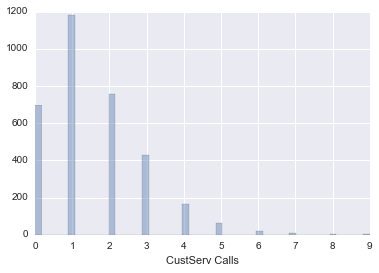

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

sb.distplot(df['CustServ Calls'], kde=False)

Examine feature differences in the distribution of our features when we condition (split) our data in whether they churned or not.

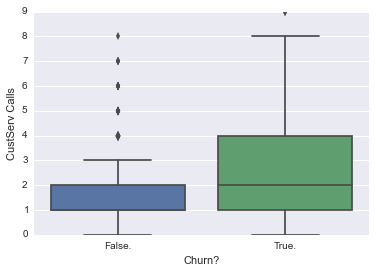

In [85]:
    sb.boxplot(x="Churn?", y="CustServ Calls", data=df)

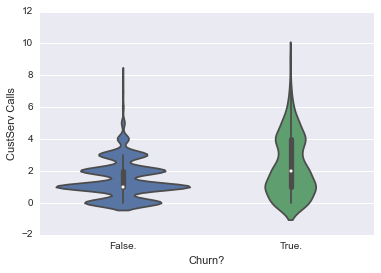

In [43]:
sb.violinplot(x="Churn?", y="CustServ Calls", data=df)


# Joint Distributions
Looking at joint distributions of data

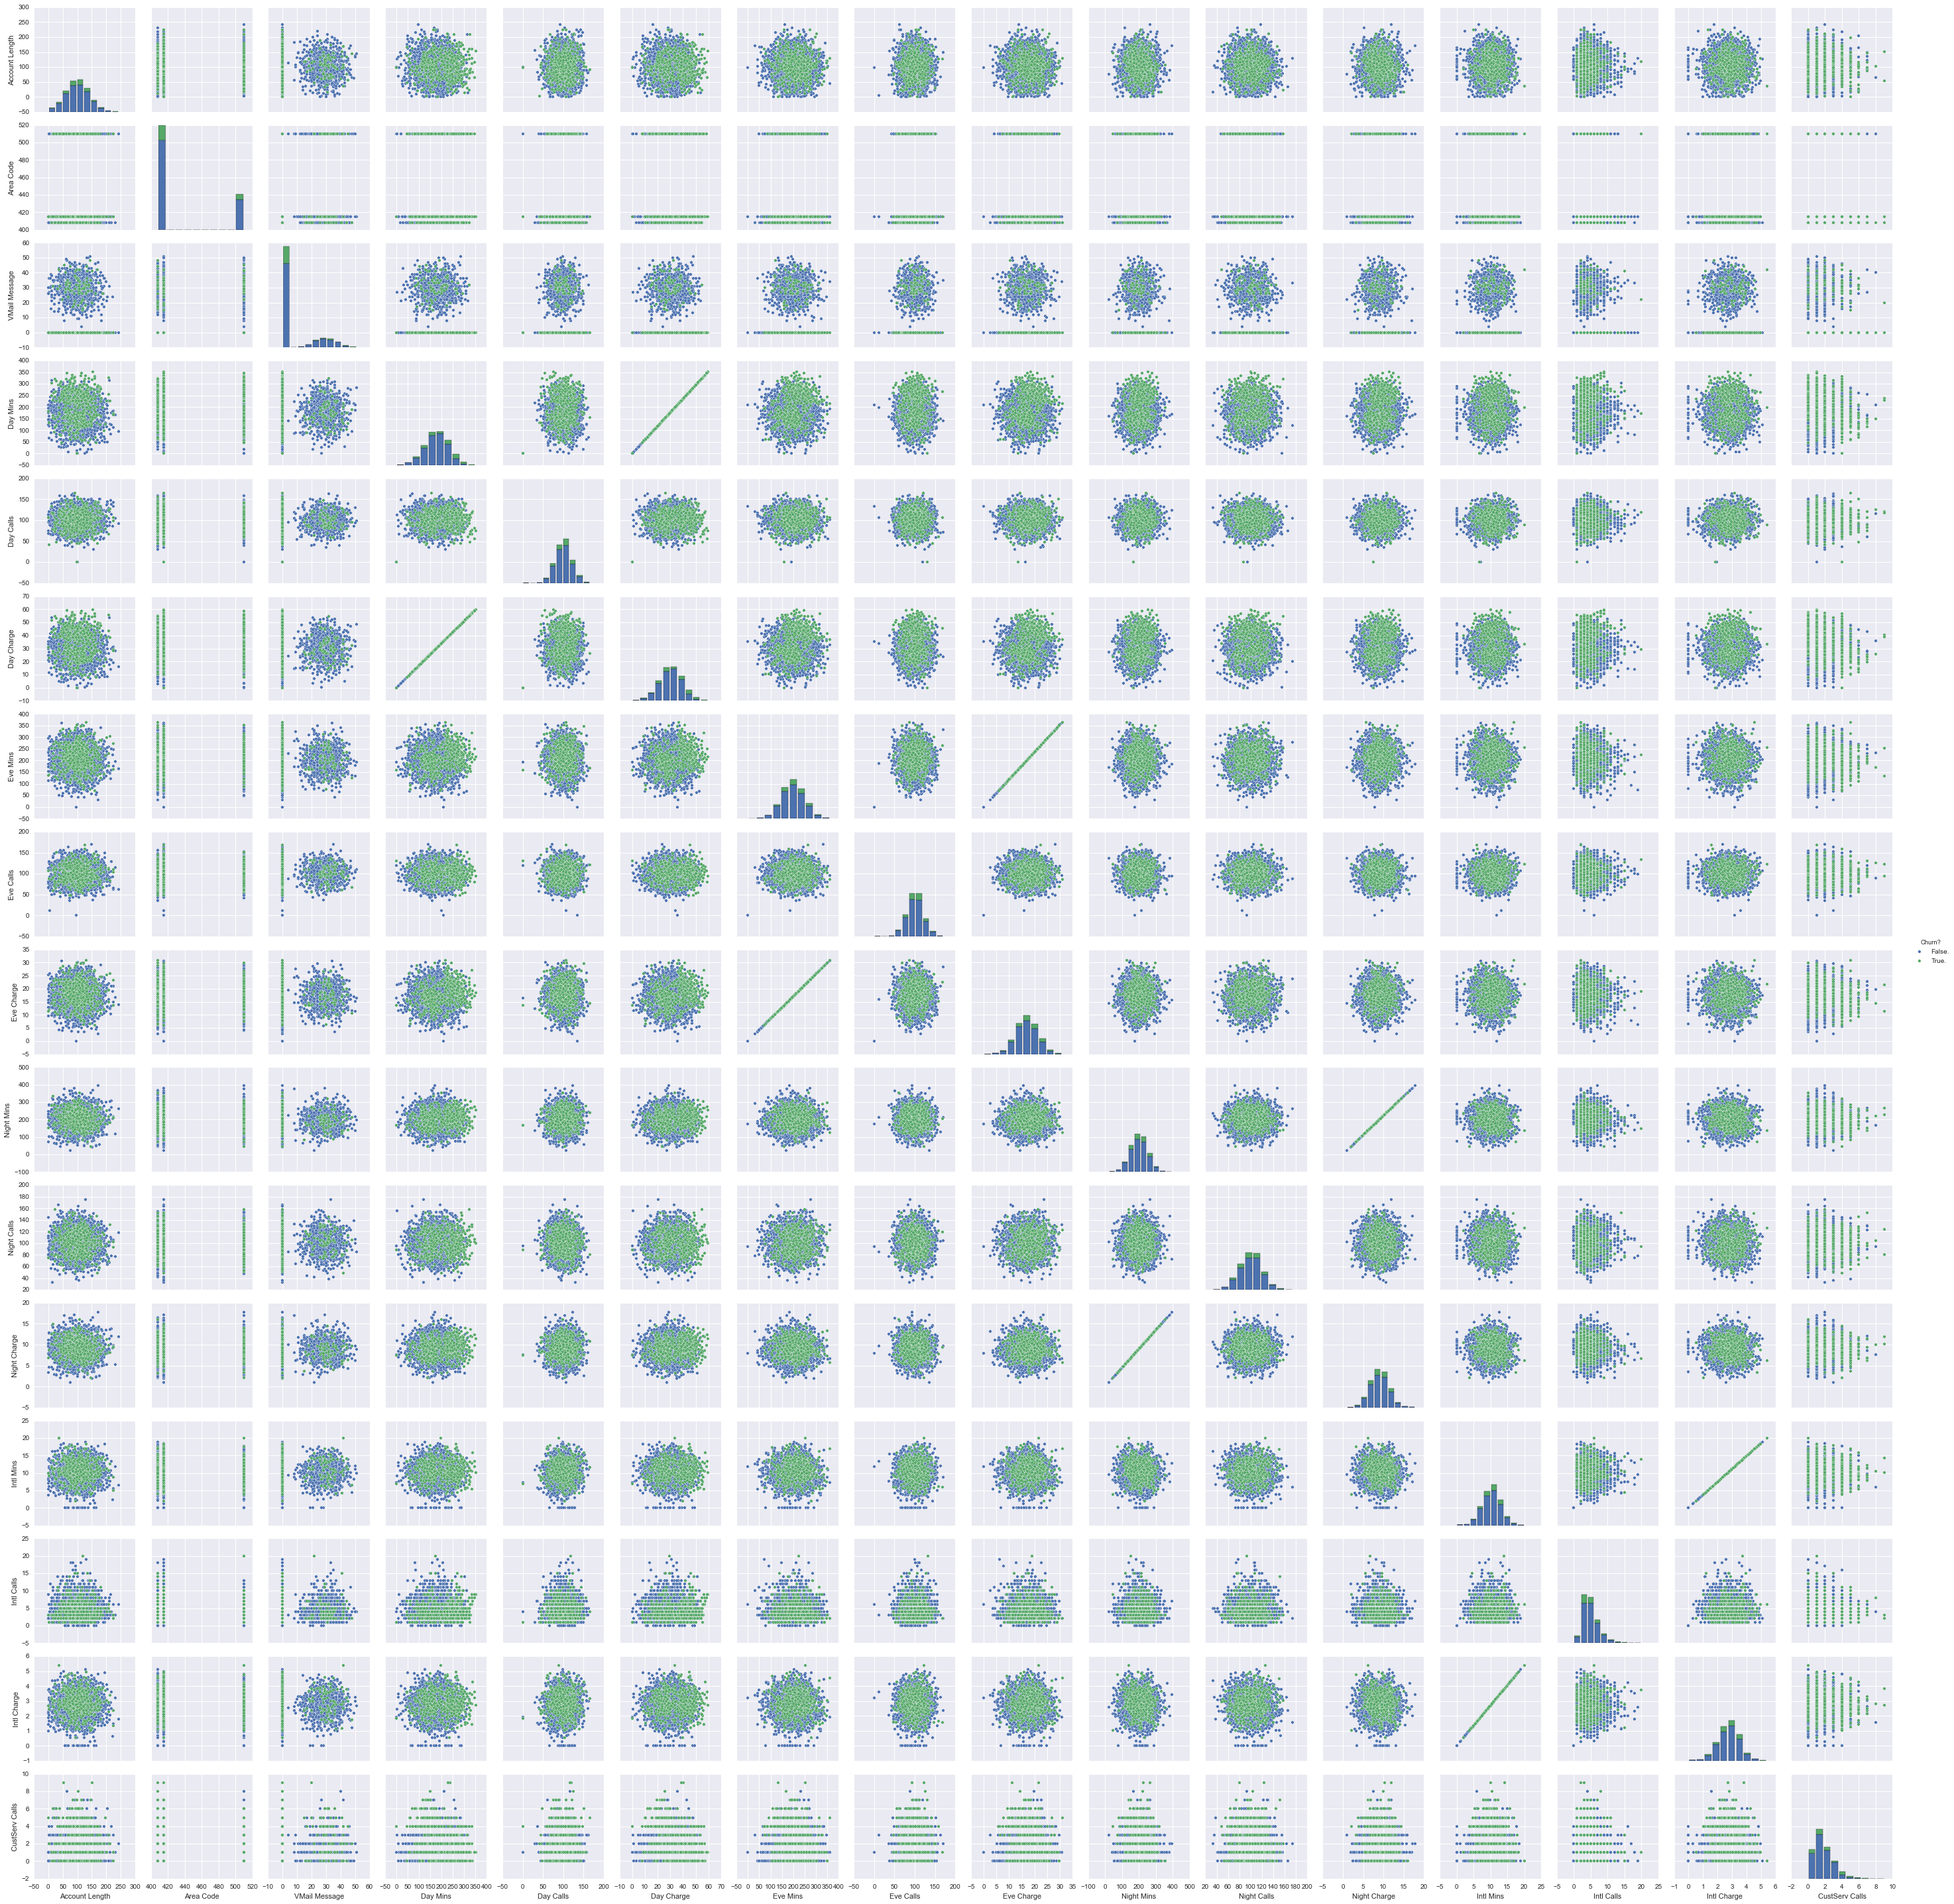

In [29]:
example_numeric_data = df[["Intl Mins", "Intl Calls" ,
                                       "Intl Charge", "Churn?"]]
 
sb.pairplot(df, hue="Churn?")

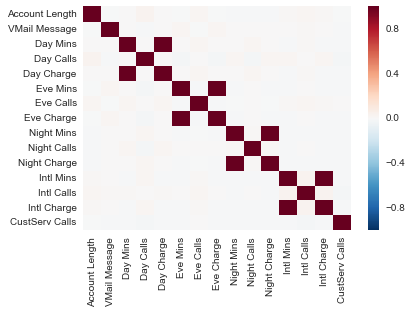

In [30]:

corr = df[[ 'Account Length','VMail Message','Day Mins','Day Calls','Day Charge',
            'Eve Mins','Eve Calls','Eve Charge','Night Mins','Night Calls',
            'Night Charge','Intl Mins','Intl Calls','Intl Charge','CustServ Calls']].corr()


sb.heatmap(corr)

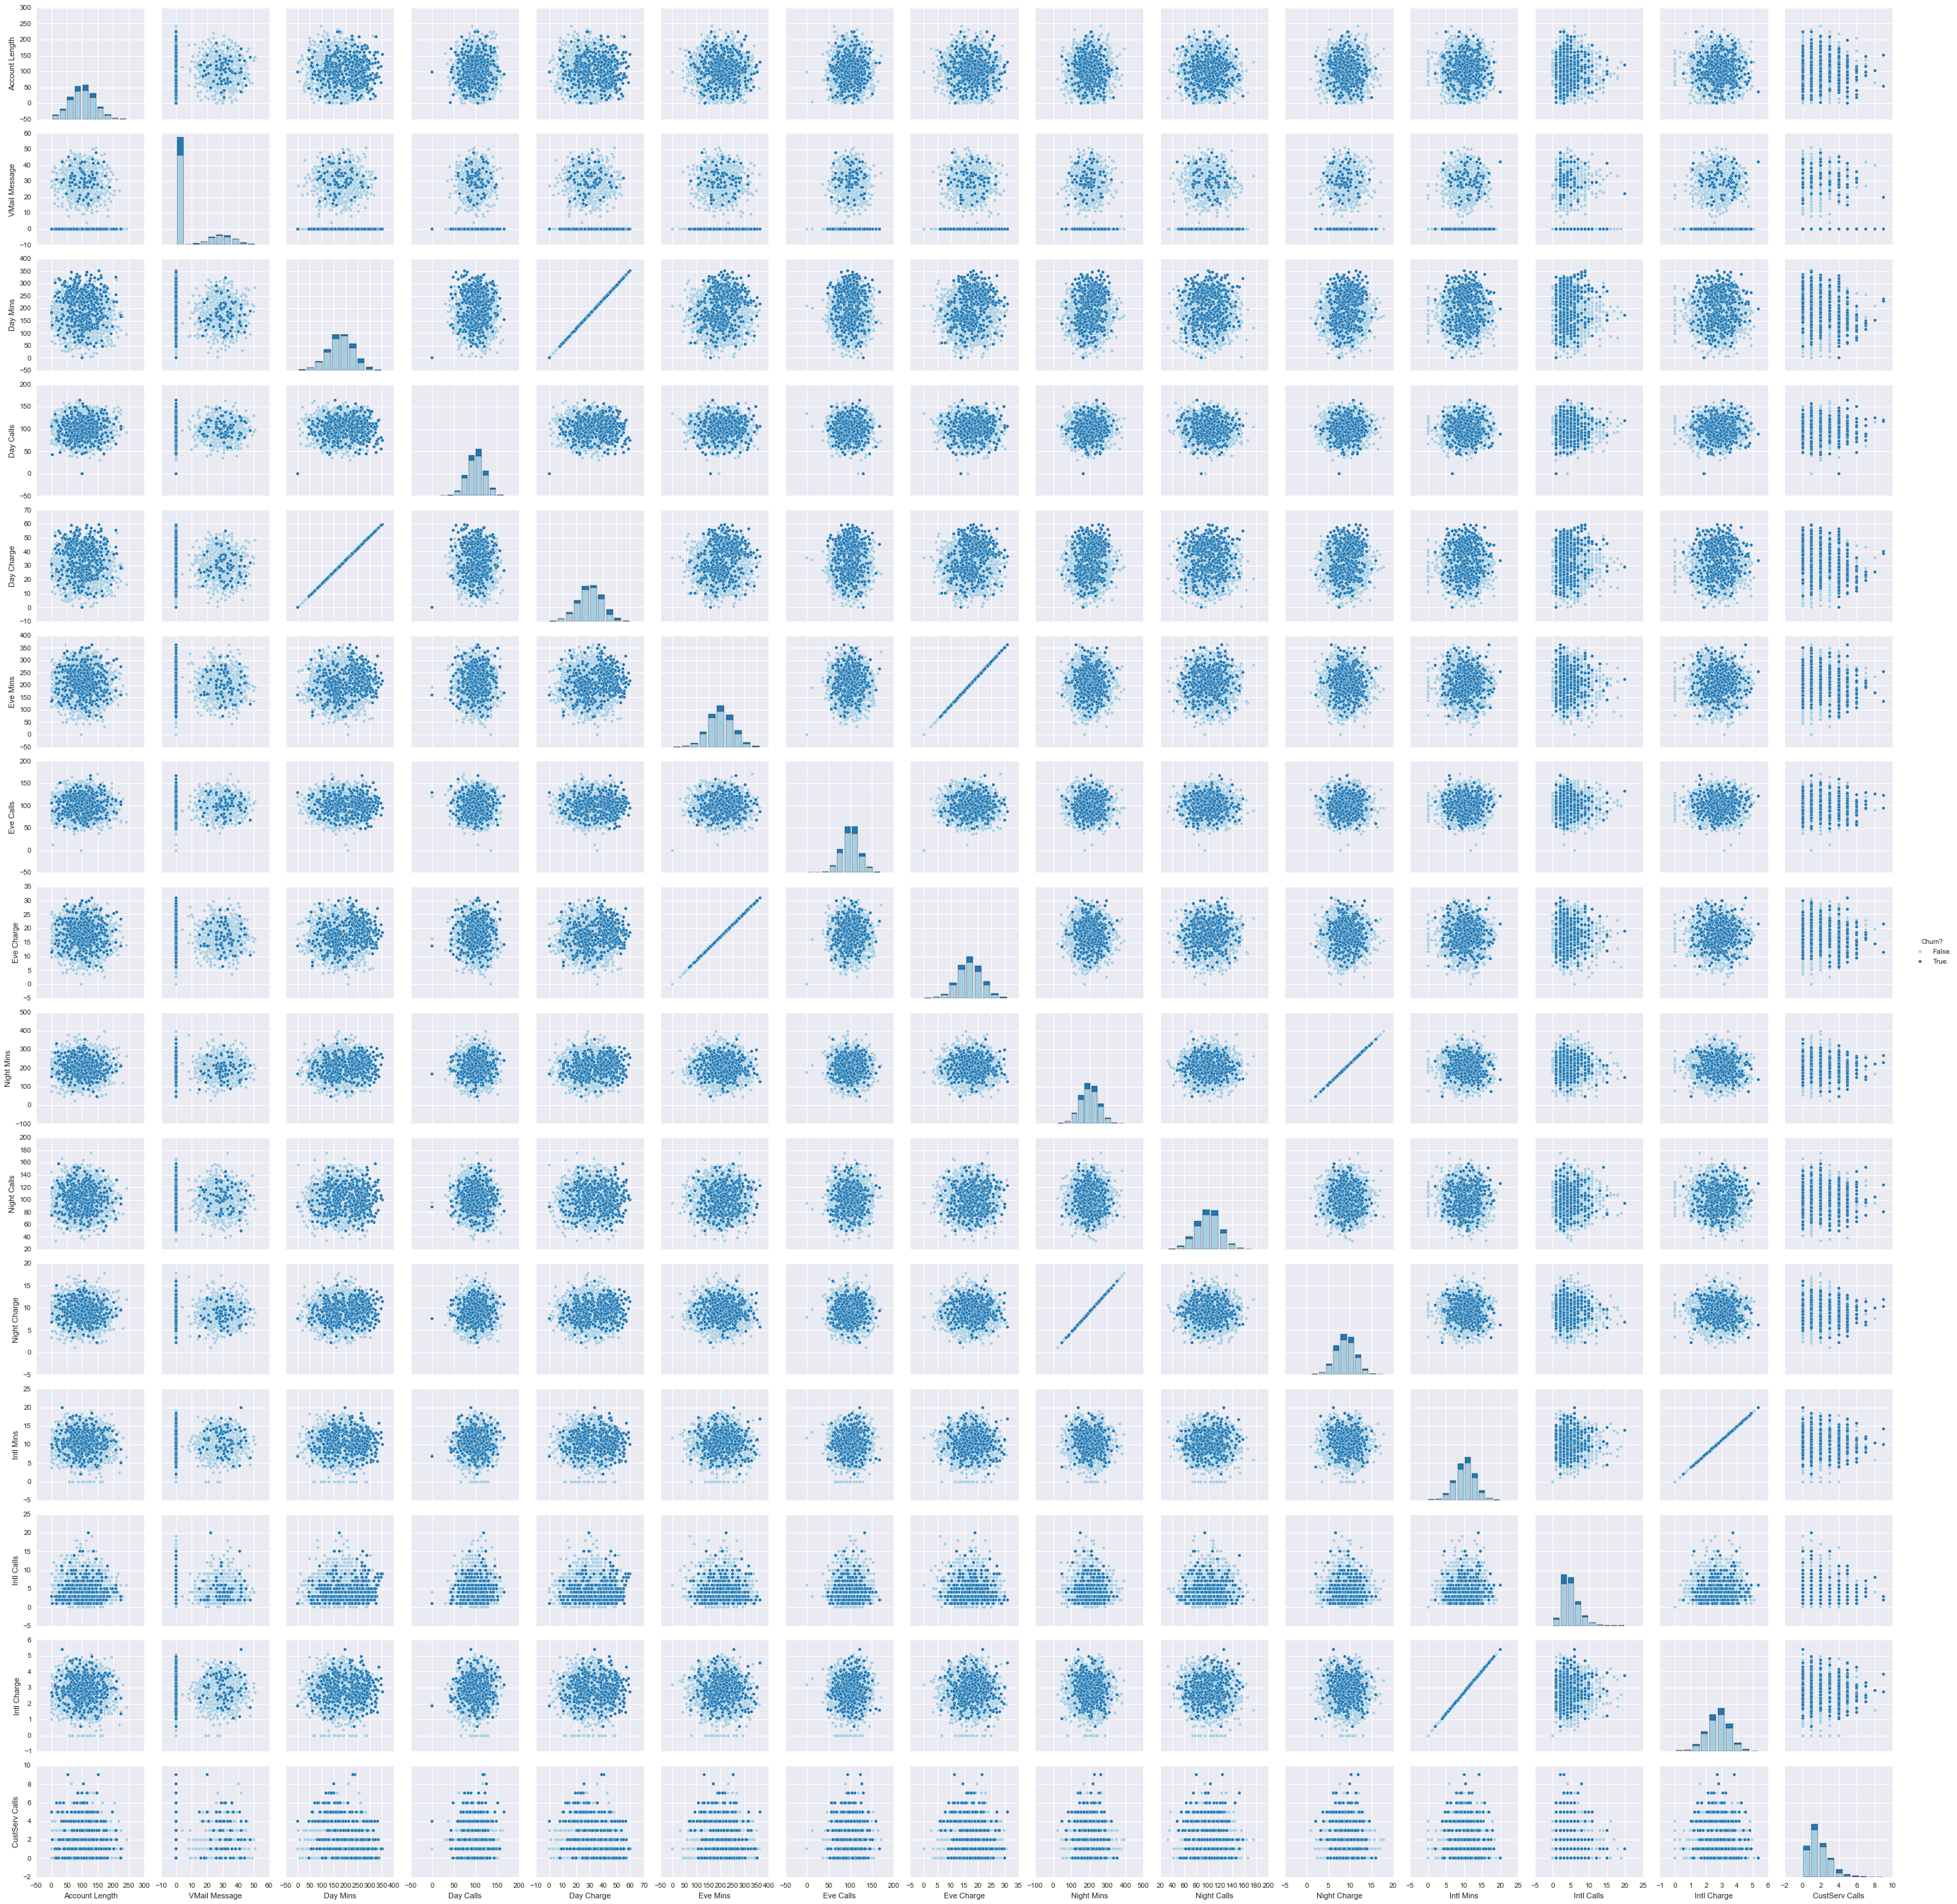

In [33]:
reduced_cols = ['Account Length','VMail Message','Day Mins','Day Calls','Day Charge',
            'Eve Mins','Eve Calls','Eve Charge','Night Mins','Night Calls',
            'Night Charge','Intl Mins','Intl Calls','Intl Charge','CustServ Calls']
sb.pairplot(df[reduced_cols + ['Churn?']], hue="Churn?", palette='Paired')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(normalized_feats, labels, train_size=2500, random_state=0)

In [14]:
lr = LogisticRegression(class_weight='auto')
XX_train, XX_valid, yy_train, yy_valid = train_test_split(X_train, y_train, train_size=1750, random_state=0) 
lr.fit(XX_train, yy_train)
yy_pred = lr.predict(XX_valid)
print(classification_report(yy_valid, yy_pred))

             precision    recall  f1-score   support

     False.       0.94      0.80      0.87       639
      True.       0.38      0.70      0.50       111

avg / total       0.86      0.79      0.81       750



In [15]:
svc_clf = SVC()
X1_train, X1_valid, y1_train, y1_valid = train_test_split(X_train, y_train, train_size=1750, random_state=0) 
svc_clf.fit(X1_train, y1_train)
y1_pred = svc_clf.predict(X1_valid)
print(classification_report(y1_valid, y1_pred))

             precision    recall  f1-score   support

     False.       0.91      0.99      0.95       639
      True.       0.87      0.42      0.57       111

avg / total       0.90      0.91      0.89       750



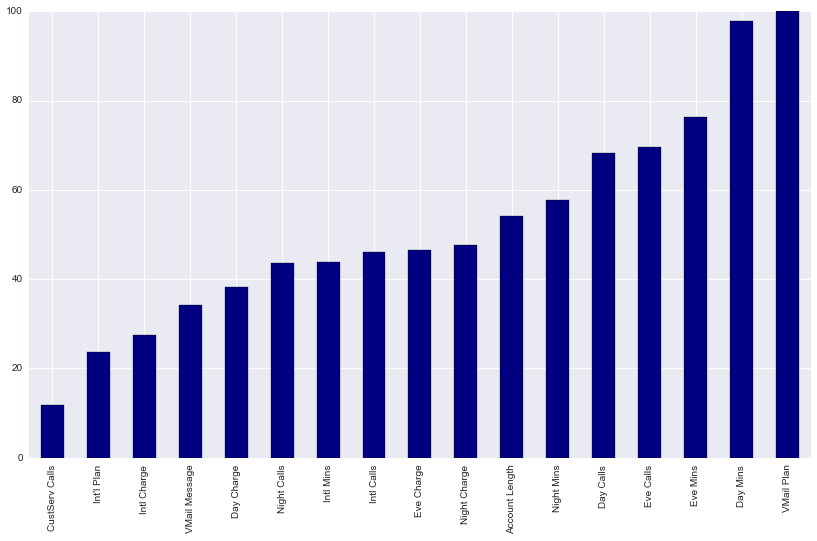

In [42]:
%matplotlib inline
gb = GradientBoostingClassifier(max_depth=7, max_features='auto', learning_rate=0.1)
gb.fit(XX_train, yy_train)
importance_s = pd.Series(gb.feature_importances_, index=list(features_names))
importance_s /= importance_s.max()
importance_s *= 100
importance_s.sort_values(inplace=True)
sns.set_style("darkgrid")
importance_s.plot(kind='bar', color='navy', figsize=(14,8))

In [17]:
# grid search
param_grid = {'n_estimators': np.arange(80, 136, 8), 'max_depth': [3, 4, 5, 6, 7]}
grid_search = GridSearchCV(gb, param_grid=param_grid, cv=3, verbose=0, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=7, max_features='auto', max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid={'n_estimators': array([ 80,  88,  96, 104, 112, 120, 128]), 'max_depth': [3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [18]:
print("the winner is :", grid_search.best_params_)
print("with a score of : %f" % grid_search.best_score_)

('the winner is :', {'n_estimators': 120, 'max_depth': 6})
with a score of : 0.949200


In [19]:
gb_best = GradientBoostingClassifier(n_estimators=120, 
                                     max_depth=6, 
                                     max_features='auto', 
                                     learning_rate=0.1)
gb_best.fit(X_train, y_train)
y_pred = gb_best.predict(X_test)
proba_pred = gb_best.predict_proba(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

     False.       0.97      0.98      0.98       718
      True.       0.88      0.80      0.84       115

avg / total       0.96      0.96      0.96       833



In [20]:
from sklearn.cross_validation import KFold

def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
    
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

In [21]:
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN

def accuracy(y_true,y_pred):
    # NumPy interprets True and False as 1. and 0.
    return np.mean(y_true == y_pred)

print "Random forest:"
print "%.3f" % accuracy(y, run_cv(X,y,RF))
print "K-nearest-neighbors:"
print "%.3f" % accuracy(y, run_cv(X,y,KNN))

Random forest:
0.944
K-nearest-neighbors:
0.878
